In [4]:
import numpy as np
from hottbox.core import Tensor
import yfinance as yf
import alphalens
import pandas as pd
from hottbox.pdtools import tensor_to_pd, pd_to_tensor
from hottbox.utils.generation import residual_tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD, Parafac2
from hottbox.metrics import residual_rel_error, mse, rmse, mape
from hottbox.rank import rank_estimation as re
from matplotlib import pyplot as plt

In [5]:
# pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-20", end="2019-05-21")
pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-20", end="2019-05-21")

[*********************100%***********************]  20 of 20 completed


In [6]:
pan["Adj Close"]

,BAC,BCS,BNPQY,BNS,C,CS,GS,HDB,HSBC,JPM,LYG,MS,PNC,RY,SCHW,TD,TFC,UBS,USB,WFC
Date,,,,,,,,,,,,,,,,,,,,
2011-05-19,10.217743,12.834218,26.009302,38.390888,36.145077,29.249418,118.947029,14.833581,30.952944,33.291256,2.739781,20.195780,48.373867,42.301365,15.578585,29.621403,20.067228,14.420515,19.813374,21.381483
2011-05-20,10.121597,12.614285,25.608244,38.149796,35.830624,29.171848,115.233727,14.786564,30.708990,32.632988,2.644484,19.805164,47.375179,42.171463,15.313341,29.570139,19.516129,14.203665,19.345104,20.925606
2011-05-23,9.981748,12.280837,25.040247,37.712025,35.079422,28.720551,115.959290,14.555243,30.131813,32.194149,2.580953,19.688805,46.929638,41.583477,15.198402,29.477863,19.178120,13.932602,19.137833,20.574354
2011-05-24,10.016708,12.280837,25.074883,37.775471,35.385147,28.727602,116.386108,14.610723,30.054462,32.035255,2.533305,19.555830,46.614670,41.638165,15.322183,29.330898,19.258949,13.870645,19.160864,20.649084
2011-05-25,9.946785,12.585903,25.594391,37.997532,35.236618,29.475065,116.300774,14.512930,30.280577,31.982307,2.596836,19.580769,46.944996,41.781750,15.472486,29.659006,19.596951,14.180430,19.122475,20.596771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-14,27.256250,7.606107,23.181927,47.471714,60.872921,11.398154,187.180862,57.678493,38.378349,103.506302,2.998740,41.685356,120.897499,71.453606,42.921913,50.259369,44.486950,10.845539,47.420773,43.543602
2019-05-15,26.941975,7.653001,23.081570,47.409000,60.509144,11.398154,187.295273,57.042976,38.751659,103.112236,2.998740,41.581173,119.891273,71.646622,41.373089,50.378296,44.070225,10.827171,47.179256,42.934792
2019-05-16,27.227682,7.690516,23.355267,47.588177,61.544521,11.455817,189.908264,58.100517,38.908287,104.435150,2.989098,41.941093,122.145996,71.913177,42.341110,50.561260,44.625854,11.010839,47.838787,42.990990


In [7]:
returns = pan["Adj Close"].apply(np.log).diff(1)
returns = returns.stack()
returns.index = returns.index.set_names(['date', 'asset'])
returns = returns.unstack()
# returns.index = returns.index.tz_localize('UTC')
returns = returns.stack()
returns

date        asset
2011-05-20  BAC     -0.009454
            BCS     -0.017285
            BNPQY   -0.015540
            BNS     -0.006300
            C       -0.008738
                       ...   
2019-05-20  TD       0.006495
            TFC      0.009562
            UBS      0.003339
            USB      0.003098
            WFC     -0.005486
Length: 40240, dtype: float64

In [8]:
# pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-21", end="2019-05-21")
pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-21", end="2019-05-21")

vol = pan["Volume"]
vol = vol.stack()
vol.index = vol.index.set_names(['date', 'asset'])
vol = vol.unstack()
vol = vol.stack()
vol

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  BAC      115821500
            BCS        2534343
            BNPQY        36200
            BNS         250400
            C         31538600
                       ...    
2019-05-20  TD         2028300
            TFC        4101600
            UBS        3034400
            USB        4573000
            WFC       18854000
Length: 40240, dtype: int64

In [9]:
# pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-14", end="2019-05-21")
pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-14", end="2019-05-21")

predictive_factor = pan['Open']
predictive_factor = -predictive_factor.pct_change(5)

predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])

pricing = pan['Open'].iloc[1:]
pricing.index = pricing.index.tz_localize('UTC')

predictive_factor = predictive_factor.unstack()
# factor.index = factor.index.tz_localize('UTC')
predictive_factor = predictive_factor.stack()

predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  BAC      0.045902
            BCS     -0.002224
            BNPQY    0.017992
            BNS     -0.007718
            C        0.027206
                       ...   
2019-05-20  TD      -0.008044
            TFC      0.021455
            UBS     -0.008475
            USB     -0.000583
            WFC      0.014261
Length: 40240, dtype: float64

In [10]:
# pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-07", end="2019-05-21")
pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-07", end="2019-05-21")

non_predictive_factor = pan["Open"].pct_change(10)
non_predictive_factor = non_predictive_factor.stack()
non_predictive_factor.index = non_predictive_factor.index.set_names(['date', 'asset'])
non_predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  BAC     -0.062047
            BCS     -0.019576
            BNPQY   -0.049230
            BNS     -0.005629
            C       -0.096264
                       ...   
2019-05-20  TD      -0.016937
            TFC     -0.047723
            UBS     -0.045710
            USB     -0.021846
            WFC     -0.049385
Length: 40240, dtype: float64

In [11]:
from datetime import datetime

data = {'Date': list(returns.index.get_level_values('date')),
        'Asset': list(returns.index.get_level_values('asset')),
        'Returns': returns,
        'Volume': vol,
        'Predictive Factor': predictive_factor,
        'Non-Predictive Factor': non_predictive_factor
       }

df_original = pd.DataFrame.from_dict(data)
df_original.set_index(["Date","Asset","Returns","Volume","Predictive Factor","Non-Predictive Factor"], inplace=True)
df_original

Empty DataFrame
Columns: []
Index: [(2011-05-20 00:00:00, BAC, -0.00945422467325674, 115821500, 0.04590159628667356, -0.062046697305151555), (2011-05-20 00:00:00, BCS, -0.017285023767561913, 2534343, -0.0022235047307423983, -0.01957582211487119), (2011-05-20 00:00:00, BNPQY, -0.015539919983324157, 36200, 0.017992142220673135, -0.049230010928852264), (2011-05-20 00:00:00, BNS, -0.006299747204592254, 250400, -0.007718169646760309, -0.005629141456928832), (2011-05-20 00:00:00, C, -0.008737813568637787, 31538600, 0.027206092108468027, -0.0962637597387963), (2011-05-20 00:00:00, CS, -0.002655540069757212, 1503232, -0.003350885591191899, -0.028054718293531233), (2011-05-20 00:00:00, GS, -0.031715790328259885, 11284500, 0.029566730331577307, -0.08774020226986956), (2011-05-20 00:00:00, HDB, -0.003174672994298078, 2114000, 0.011228964283559795, -0.04541072668787827), (2011-05-20 00:00:00, HSBC, -0.007912660607272581, 2210000, 0.023948717461775293, -0.028710875731066787), (2011-05-20 00:00:00, JPM, -0.019971100596521296, 29946700, 0.005220143782740605, -0.03606772257797353), (2011-05-20 00:00:00, LYG, -0.03540197722520955, 3168800, 0.05084747703301684, -0.04273507002136323), (2011-05-20 00:00:00, MS, -0.01953093300810771, 12566000, 0.010204081632653073, -0.045275576212658875), (2011-05-20 00:00:00, PNC, -0.02086128271154708, 3038800, 0.007291156813442945, -0.01276793152786626), (2011-05-20 00:00:00, RY, -0.0030755922725980156, 815300, -0.015699897360621495, 0.010356686412203109), (2011-05-20 00:00:00, SCHW, -0.017172775197662027, 8851700, 0.02722220950656462, -0.03152653192641053), (2011-05-20 00:00:00, TD, -0.0017321333614033207, 1872600, -0.01866952478237116, 0.009366530711415688), (2011-05-20 00:00:00, TFC, -0.027846824162681028, 7646300, -0.0025744646358700773, 0.01338292250768558), (2011-05-20 00:00:00, UBS, -0.01515183531060238, 3114000, -0.0005364929833306942, -0.04162381829651218), (2011-05-20 00:00:00, USB, -0.023917766859472778, 10140600, -0.01816749594650746, 0.012568798652000446), (2011-05-20 00:00:00, WFC, -0.021551705005022015, 29293400, -0.006718480272127625, 0.0010548093788167456), (2011-05-23 00:00:00, BAC, -0.01391329844416278, 122134100, 0.03532380691055326, -0.06596086999640349), (2011-05-23 00:00:00, BCS, -0.026789778699877864, 3808676, 0.01531480644144978, -0.029625509791419313), (2011-05-23 00:00:00, BNPQY, -0.0224299196969846, 48300, 0.034279560098185, -0.05005262795063725), (2011-05-23 00:00:00, BNS, -0.011541397283031607, 151500, -0.011016975014896735, 0.0037018546117013607), (2011-05-23 00:00:00, C, -0.021188245660675342, 34722800, 0.018743924621288266, -0.10202713474336922), (2011-05-23 00:00:00, CS, -0.015591231702040798, 1244160, 0.005853658536585371, -0.03044719314938149), (2011-05-23 00:00:00, GS, 0.006276707175600471, 8406500, 0.051458584934401475, -0.10728121500327348), (2011-05-23 00:00:00, HDB, -0.015767615865814655, 1620000, 0.015216885622150622, -0.05809582755624909), (2011-05-23 00:00:00, HSBC, -0.018973923208016163, 3754700, 0.024296222934848233, -0.03582319139698531), (2011-05-23 00:00:00, JPM, -0.013538949349086948, 32299500, 0.013265061173644788, -0.052513932382594275), (2011-05-23 00:00:00, LYG, -0.024317219990427685, 2852600, 0.06628242569946141, -0.06086957543318405), (2011-05-23 00:00:00, MS, -0.005892547669154258, 10709200, 0.019991650881324596, -0.06441347739389891), (2011-05-23 00:00:00, PNC, -0.009449033677096264, 2820600, 0.0076460258885570065, -0.02180886140218874), (2011-05-23 00:00:00, RY, -0.014040859012704576, 374200, -0.013504524499381443, 0.0033008873153288487), (2011-05-23 00:00:00, SCHW, -0.007534101056910103, 7008300, 0.022260347420496096, -0.0488618021616688), (2011-05-23 00:00:00, TD, -0.0031254467930206253, 1487000, -0.022559076356963192, 0.008475588541124957), (2011-05-23 00:00:00, TFC, -0.01747120020154913, 3654500, 0.010931055711329907, -0.028148156625253162), (2011-05-23 00:00:00, UBS, -0.019268458054302773, 1960600, 0.014778349808356905, -0.04912838299962963), (2011-

In [12]:
tensor = []
tensor_date = []
for i in range(len(df_original.index.get_level_values('Asset'))):
    if len(tensor_date)==20:
        tensor.append(tensor_date) 
        tensor_date = []
    tensor_date.append([df_original.index.get_level_values('Returns')[i], df_original.index.get_level_values('Volume')[i], df_original.index.get_level_values('Predictive Factor')[i], df_original.index.get_level_values('Non-Predictive Factor')[i]])          

In [13]:
np.array(tensor)

array([[[-9.45422467e-03,  1.15821500e+08,  4.59015963e-02,
         -6.20466973e-02],
        [-1.72850238e-02,  2.53434300e+06, -2.22350473e-03,
         -1.95758221e-02],
        [-1.55399200e-02,  3.62000000e+04,  1.79921422e-02,
         -4.92300109e-02],
        ...,
        [-1.51518353e-02,  3.11400000e+06, -5.36492983e-04,
         -4.16238183e-02],
        [-2.39177669e-02,  1.01406000e+07, -1.81674959e-02,
          1.25687987e-02],
        [-2.15517050e-02,  2.92934000e+07, -6.71848027e-03,
          1.05480938e-03]],

       [[-1.39132984e-02,  1.22134100e+08,  3.53238069e-02,
         -6.59608700e-02],
        [-2.67897787e-02,  3.80867600e+06,  1.53148064e-02,
         -2.96255098e-02],
        [-2.24299197e-02,  4.83000000e+04,  3.42795601e-02,
         -5.00526280e-02],
        ...,
        [-1.92684581e-02,  1.96060000e+06,  1.47783498e-02,
         -4.91283830e-02],
        [-1.07722330e-02,  1.01393000e+07, -4.43014944e-03,
         -1.18858653e-02],
        [-1.692

In [14]:
from corcondia import corcondia_3d
print(corcondia_3d(np.array(tensor), k=3))

-3511.7078492378573


In [15]:
tensor_data = Tensor(np.array(tensor))
print(tensor_data)

This tensor is of order 3 and consists of 160880 elements.
Sizes and names of its modes are (2011, 20, 4) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Training

In [16]:
alg = Parafac2()
alg

Parafac2(epsilon=0.01, init='random', max_iter=50, random_state=None,
       tol=0.0001, verbose=False)

In [17]:
kruskal_rank = (18,)

tensor_cpd = alg.decompose(tensor_data, rank=kruskal_rank)
print("\tOutput of the {} algorithm:".format(alg.name))
print(tensor_cpd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_cpd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_cpd.core)
tensor_cpd.core.data

TypeError: Parameter `tenl` should be a list of np.ndarray objects!

In [18]:
print('\n\Factor tensor')
for mode, fmat in enumerate(tensor_cpd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
tensor_cpd.fmat


\Factor tensor
Mode-0 factor matrix is of shape (2011, 18)
Mode-1 factor matrix is of shape (20, 18)
Mode-2 factor matrix is of shape (4, 18)


[array([[ 1.41593690e+10,  4.05508377e+09, -3.34405787e+07, ...,
          3.13691971e+07,  5.81292761e+08,  4.52291183e+09],
        [ 2.48127715e+10,  4.03360778e+09, -4.04021236e+07, ...,
          1.65202083e+06,  1.06279180e+09,  5.07033117e+09],
        [ 9.24682405e+10, -1.00891456e+10, -2.02788256e+07, ...,
         -2.47718074e+08,  3.98214506e+09, -1.50322702e+10],
        ...,
        [ 7.03129448e+09, -2.70330125e+09, -6.50384164e+06, ...,
         -4.72735040e+07,  2.33495964e+08, -2.15505894e+09],
        [-9.66336514e+10,  4.53505487e+09,  3.89162674e+07, ...,
          1.81308278e+08, -4.18624372e+09,  9.09188728e+09],
        [-1.80262726e+11,  1.91729345e+10,  6.52429928e+07, ...,
          4.67656747e+08, -7.56332355e+09,  2.64222627e+10]]),
 array([[-6.84216758e+00, -5.41592207e+00,  1.72148477e+00,
         -5.45970890e+00,  1.74631824e+00, -4.27803982e+00,
         -9.46502517e+00, -1.41337564e+00,  1.21148360e+01,
         -2.13076018e+00,  7.53408253e+00, -7.625

In [19]:
# index = sorted(["GOOGL", "AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])
index = sorted(["BAC", "JPM", "GS", "C", "MS", "HSBC", "BNPQY", "BCS", "LYG", "UBS", "CS", "WFC", "RY", "SCHW", "TD", "HDB", "USB", "PNC", "TFC", "BNS"])


df = pd.DataFrame(tensor_cpd.fmat[1], columns = [i for i in range(tensor_cpd.fmat[1].shape[1])], index = index)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
BAC,-6.842168,-5.415922,1.721485,-5.459709,1.746318,-4.278040,-9.465025,-1.413376,12.114836,-2.130760,7.534083,-7.625166,5.608287,12.042191,5.684341,-2.385668,3.581843,-5.357305
BCS,0.919247,-0.278072,0.187058,0.030967,3.141778,-0.128191,-2.250404,1.029644,-3.023386,1.454229,-2.173137,0.497676,1.651471,0.335859,-1.989403,-5.162663,1.899186,0.104339
BNPQY,-0.011648,0.017621,0.069058,0.024496,-0.084937,-0.038566,-0.055877,-0.094435,0.056803,0.024294,0.043896,0.033561,-0.117151,0.029110,0.029450,-0.026587,0.054019,0.025263
BNS,0.004948,-0.093174,0.044606,0.097742,-0.064513,-0.110967,-0.315646,0.039209,-0.069413,0.136033,0.046694,0.076603,-0.109359,0.161231,0.021775,-0.398233,0.133191,0.061438
C,0.544208,-4.098827,7.167780,-0.236446,3.719132,-5.590860,-8.930865,0.027699,3.793822,0.130921,0.710394,-9.562059,-2.134107,2.476769,-5.176561,-1.053232,6.937559,1.913201
CS,0.017299,0.135061,-0.166342,0.289693,0.588225,-0.304440,-2.075116,0.295473,-0.957792,1.338650,-0.791891,1.105162,0.024829,0.941490,0.059745,-2.471172,1.074171,0.160542
GS,-0.369019,-0.354495,0.715914,0.245507,-0.219068,-1.051322,-0.895201,-0.417652,0.525828,0.155924,0.228903,-0.373161,-0.447156,0.878473,-0.035986,-0.102039,0.568355,0.315758
HDB,-0.015797,-0.147417,0.521585,0.090689,-0.126320,-0.289468,-0.671117,-0.135518,0.213108,0.248379,0.280102,-0.197512,-0.375182,0.205956,-0.000964,-0.607422,0.387461,0.153204
HSBC,-0.037995,-0.428667,-0.262838,0.215679,-0.105471,-0.261634,-0.752176,0.281320,-0.453652,0.646443,0.144425,0.394799,-0.154188,0.442534,0.098793,-1.148671,0.295369,0.173753
JPM,-0.242012,-4.145452,1.059383,0.219152,3.871637,-2.064374,-2.365433,-1.779475,-11.018198,12.763299,2.265203,6.360119,2.036126,0.903274,-2.056250,0.135555,1.142308,2.114910


In [20]:
from sklearn.decomposition import PCA
pca = PCA(1).fit(df.transpose())
pca.components_[0]

array([-0.69125001, -0.06974646, -0.00219589, -0.01103316, -0.45219399,
       -0.05672027, -0.05298524, -0.02913416, -0.02478345, -0.00803158,
       -0.13693677, -0.25565218, -0.04791508, -0.01330903, -0.15419557,
       -0.01812198, -0.09223848, -0.03697081, -0.10864282, -0.41567455])

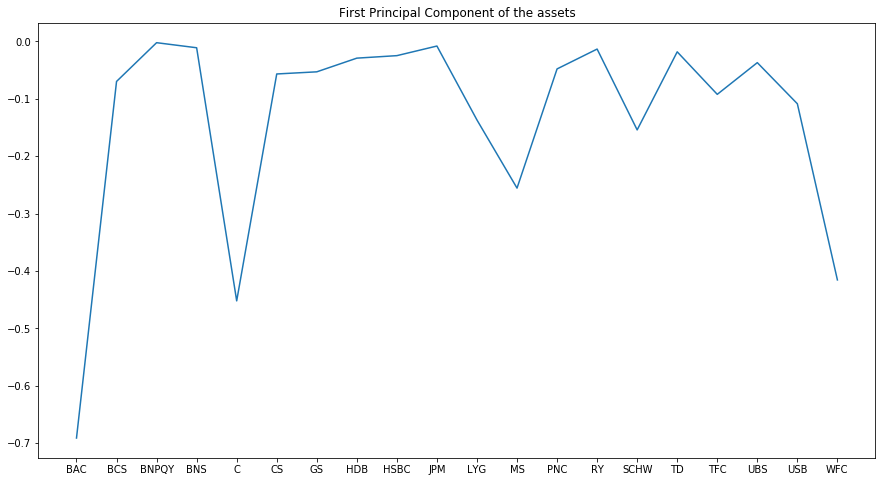

In [21]:
fig, axes = plt.subplots(1)
pc1 = pd.Series(index=index, data=pca.components_[0])
pc1.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='First Principal Component of the assets')
fig.set_size_inches(15, 8) 

In [22]:
pc1.sort_values()

BAC     -0.691250
C       -0.452194
WFC     -0.415675
MS      -0.255652
SCHW    -0.154196
LYG     -0.136937
USB     -0.108643
TFC     -0.092238
BCS     -0.069746
CS      -0.056720
GS      -0.052985
PNC     -0.047915
UBS     -0.036971
HDB     -0.029134
HSBC    -0.024783
TD      -0.018122
RY      -0.013309
BNS     -0.011033
JPM     -0.008032
BNPQY   -0.002196
dtype: float64

In [24]:
# df_dominant_assets = df.loc[["TSLA","AMD","T","NVDA","QCOM"],:]
# df_dominant_assets


In [25]:
# dominant_assets = "TSLA AMD T NVDA QCOM INTC AMAT IBM AMZN XLNX"
dominant_assets = "BNPQY JPM BNS RY TD HSBC HDB UBS PNC GS"

In [ ]:
# df_dominant_assets.to_numpy()

In [ ]:
# tensor_cpd.fmat[1]=df_dominant_assets.to_numpy()

In [ ]:
# tensor_full = tensor_cpd.reconstruct()
# print(tensor_full)
# tensor_full.data

In [ ]:
# arr = tensor_full.data
# df_reconstructed =  pd.concat([pd.DataFrame(x) for x in arr], keys=np.arange(arr.shape[0]))
# df_reconstructed

In [ ]:
# tensor_returns = []
# for i in range(0,tensor_full.shape[0],1):
#     tensor_returns.append(np.array(tensor)[i,:,0].mean())
# tensor_returns

In [ ]:
# mean_returns = []
# for i in range(0,tensor_full.shape[0],1):
#     mean_returns.append(tensor_full.data[i,:,0].mean())
# mean_returns

In [ ]:
# df = pd.Series(mean_returns,index=sorted(list(set(returns.index.get_level_values('date'))))[:-1])

# Testing

In [26]:
test = yf.download(dominant_assets, start="2019-05-19", end="2021-05-20")
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  BNPQY    0.016293
            BNS      0.006374
            GS       0.009436
            HDB     -0.007129
            HSBC     0.006258
                       ...   
2021-05-19  JPM     -0.007667
            PNC     -0.005274
            RY      -0.005511
            TD      -0.012105
            UBS     -0.000644
Length: 5040, dtype: float64

In [27]:
test = yf.download(dominant_assets, start="2019-05-22", end="2021-05-20")
vol = test["Volume"]
vol = vol.stack()
vol.index = vol.index.set_names(['date', 'asset'])
vol = vol.unstack()
vol = vol.stack()
vol

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  BNPQY      222900
            BNS        508600
            GS        2327600
            HDB       1864600
            HSBC      1550400
                       ...   
2021-05-19  JPM      13278900
            PNC       2594300
            RY        1531500
            TD        1767000
            UBS       2948000
Length: 5040, dtype: int64

In [28]:
test = yf.download(dominant_assets, start="2019-05-15", end="2021-05-20")

predictive_factor = test['Open']
predictive_factor = -predictive_factor.pct_change(5)

predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])

pricing = pan['Open'].iloc[1:]
pricing.index = pricing.index.tz_localize('UTC')

predictive_factor = predictive_factor.unstack()
# factor.index = factor.index.tz_localize('UTC')
predictive_factor = predictive_factor.stack()

predictive_factor

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  BNPQY    0.001982
            BNS     -0.007377
            GS      -0.018821
            HDB     -0.055632
            HSBC     0.011860
                       ...   
2021-05-19  JPM     -0.008709
            PNC      0.024592
            RY      -0.021957
            TD      -0.027142
            UBS     -0.013158
Length: 5040, dtype: float64

In [29]:
test = yf.download(dominant_assets, start="2019-05-08", end="2021-05-20")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-14", end="2021-05-20")
non_predictive_factor = test["Open"].pct_change(10)
non_predictive_factor = non_predictive_factor.stack()
non_predictive_factor.index = non_predictive_factor.index.set_names(['date', 'asset'])
non_predictive_factor

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  BNPQY   -0.041127
            BNS     -0.014616
            GS      -0.023016
            HDB      0.043342
            HSBC    -0.037431
                       ...   
2021-05-19  JPM      0.032051
            PNC     -0.008727
            RY       0.050879
            TD       0.058258
            UBS      0.013158
Length: 5040, dtype: float64

In [32]:
mean_returns = []
for i in range(0,len(returns_test),10):
    mean_returns.append(returns_test[i:i+10].mean())
mean_returns

[0.004336234625201341,
 -0.007381186542444462,
 -0.013241649012938029,
 0.013308956082541946,
 -0.010618938119005827,
 -0.004182343440319114,
 -0.004711548693513423,
 -0.011297633492773417,
 0.006451971914627252,
 0.02288005400972053,
 0.0003925148896297692,
 0.0004951596671114,
 0.0019902286538249214,
 0.007264011781711943,
 0.0035433590586148255,
 -0.013384310328071658,
 -0.0004627878107345218,
 0.00011597376176508689,
 -0.00632995499813509,
 0.014497113551828367,
 0.0036489889305565625,
 0.005020600403268105,
 -0.007092960991586228,
 0.002063722800464118,
 -0.004711673930039906,
 0.004487111263816468,
 0.006265932930397478,
 0.01212171811431495,
 0.006099825174684259,
 0.0005158207407998106,
 0.0058596273095082195,
 0.0033344807318549385,
 -0.009663736324576977,
 -0.0013021930041929419,
 0.001230196446764431,
 0.007259986454938483,
 0.00014515332954334603,
 -0.004453429712615975,
 0.00047820396949198595,
 -0.0033199375442999556,
 0.005402145167556815,
 -0.008554116039965231,
 -0.002

In [33]:
df = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,11.28%
Cumulative returns,23.832%
Annual volatility,33.221%
Sharpe ratio,0.49
Calmar ratio,0.25
Stability,0.00
Max drawdown,-45.838%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,45.84,2020-01-02,2020-03-23,2021-02-19,297
1,10.51,2019-07-05,2019-08-23,2019-10-21,77
2,3.98,2021-02-24,2021-02-26,2021-03-08,9
3,3.77,2019-05-21,2019-05-31,2019-06-10,15
4,3.77,2021-03-12,2021-04-20,2021-04-28,34


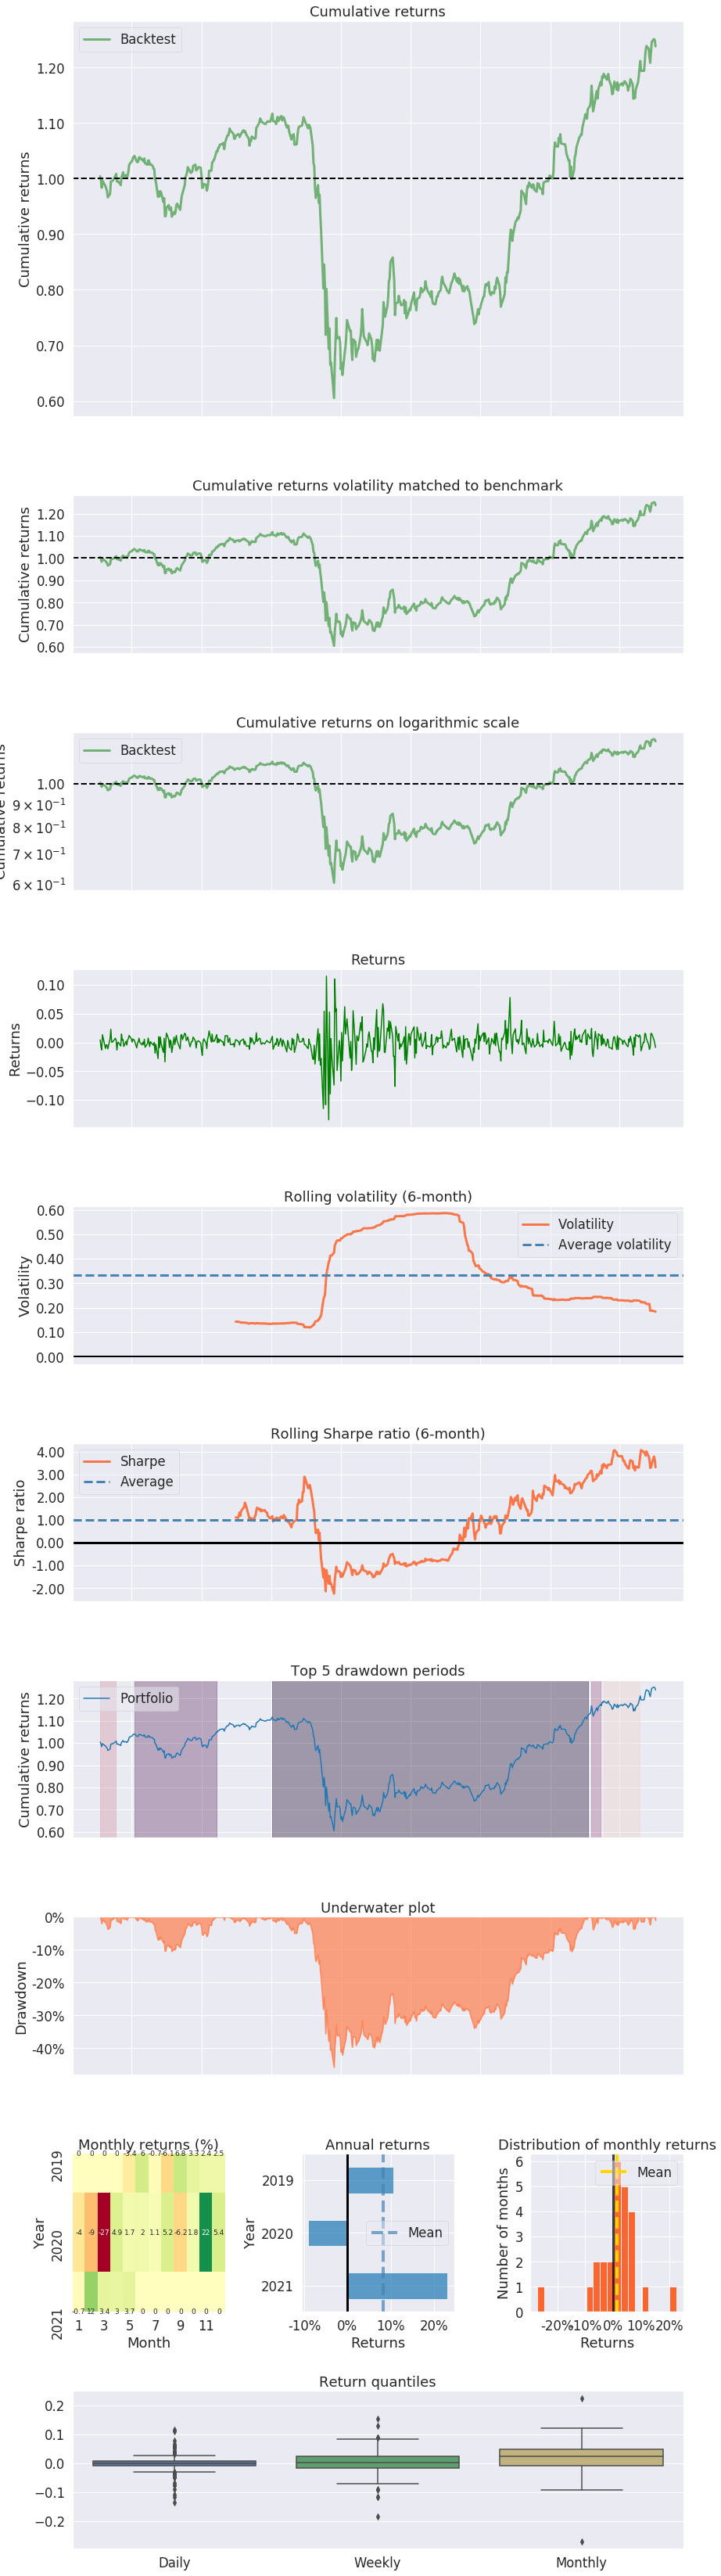

In [34]:
import pyfolio as pf
pf.create_returns_tear_sheet(df)

## Predictive Factors

In [35]:
pricing = test['Open'].iloc[1:]

In [36]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(predictive_factor,
                                                                   pricing,
                                                                   periods=(1, 3, 5),
                                                                   quantiles=5,
                                                                   bins=None)

Dropped 1.0% entries from factor data: 1.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [37]:
pf_returns, pf_positions, pf_benchmark = \
    alphalens.performance.create_pyfolio_input(factor_data,
                                               period='1D',
                                               capital=100000,
                                               long_short=True,
                                               group_neutral=False,
                                               equal_weight=True,
                                               quantiles=[1,5],
                                               groups=None,
                                               benchmark_period='1D')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/alphalens-0.4.0+0.g77084f1.dirty-py3.7.egg/alphalens/performance.py:399: UserWarning: 'freq' not set, using business day calendar


Start date,2019-05-21
End date,2021-05-12
Total months,34
,Backtest
Annual return,4.808%
Cumulative returns,14.423%
Annual volatility,9.849%
Sharpe ratio,0.53
Calmar ratio,0.64
Stability,0.68
Max drawdown,-7.468%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.47,2020-03-29,2020-04-27,2020-06-15,56
1,7.39,2020-06-15,2020-07-14,2020-08-10,41
2,6.97,2020-09-17,2020-12-03,2021-01-05,79
3,6.67,2019-12-09,2020-03-12,2020-03-27,80
4,4.83,2021-01-28,2021-02-22,2021-03-15,33


Stress Events,mean,min,max
New Normal,0.02%,-3.33%,2.75%


/Users/snehilkumar/Library/Python/3.7/lib/python/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/snehilkumar/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Top 10 long positions of all time,max
asset,
BNPQY,25.00%
BNS,25.00%
GS,25.00%
HDB,25.00%
HSBC,25.00%
JPM,25.00%
PNC,25.00%
RY,25.00%
TD,25.00%


Top 10 short positions of all time,max
asset,
BNPQY,-25.00%
BNS,-25.00%
GS,-25.00%
HDB,-25.00%
HSBC,-25.00%
JPM,-25.00%
PNC,-25.00%
RY,-25.00%
TD,-25.00%


Top 10 positions of all time,max
asset,
BNPQY,25.00%
BNS,25.00%
GS,25.00%
HDB,25.00%
HSBC,25.00%
JPM,25.00%
PNC,25.00%
RY,25.00%
TD,25.00%


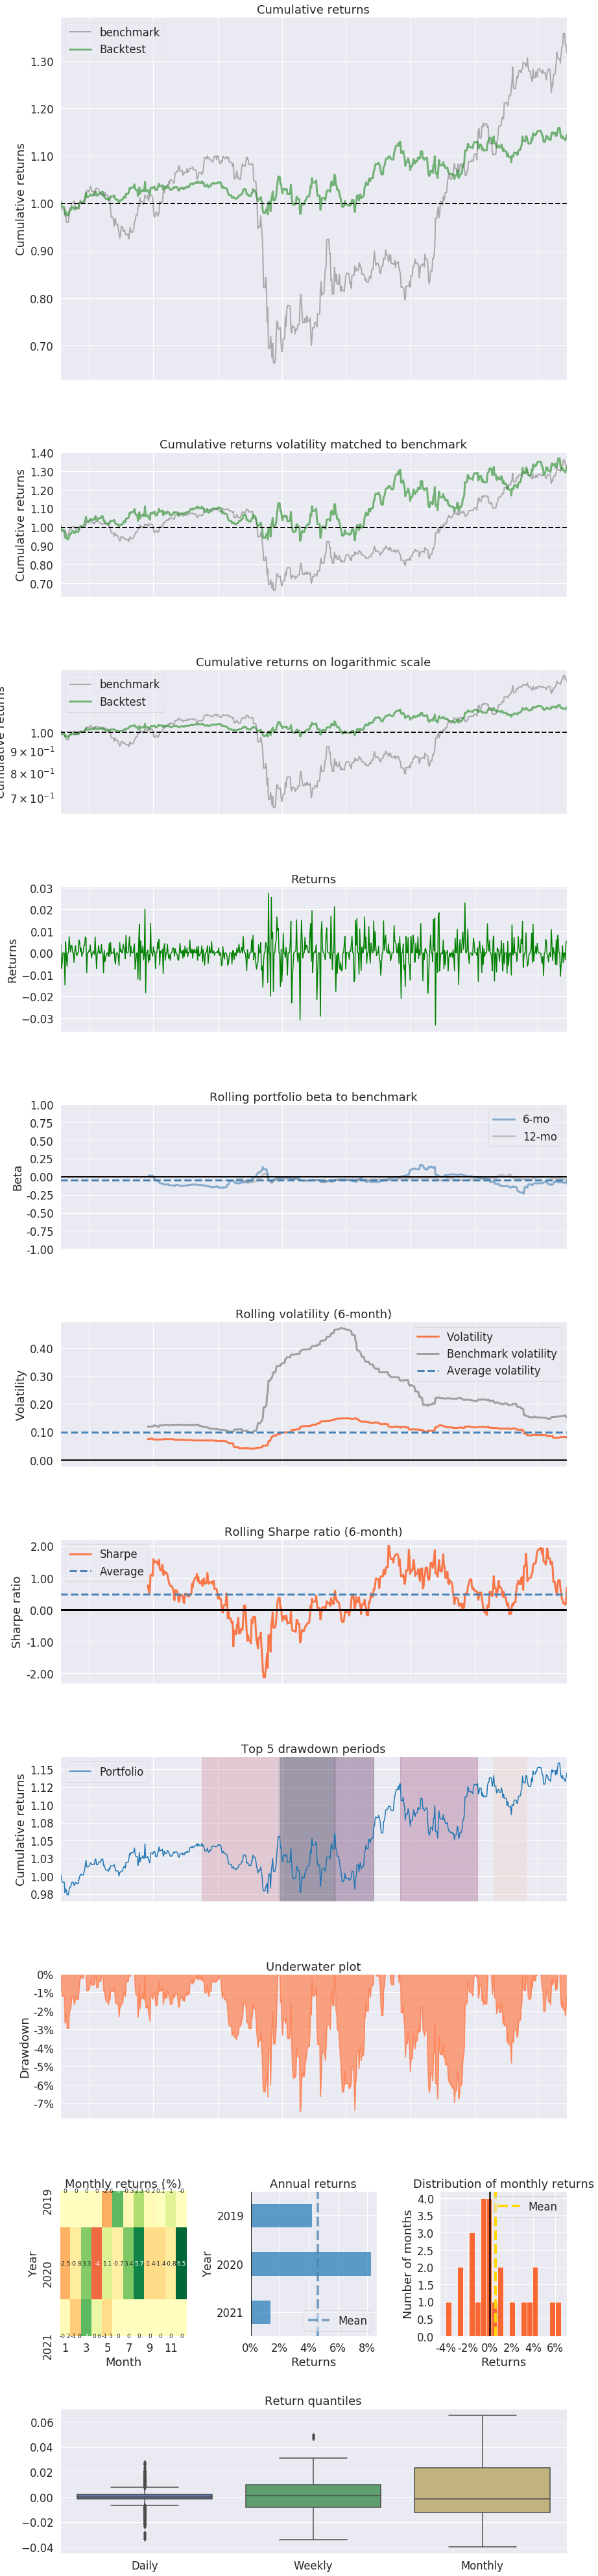

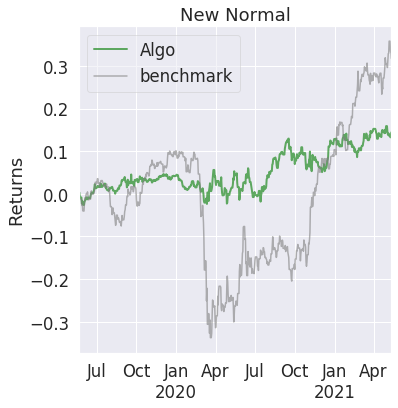

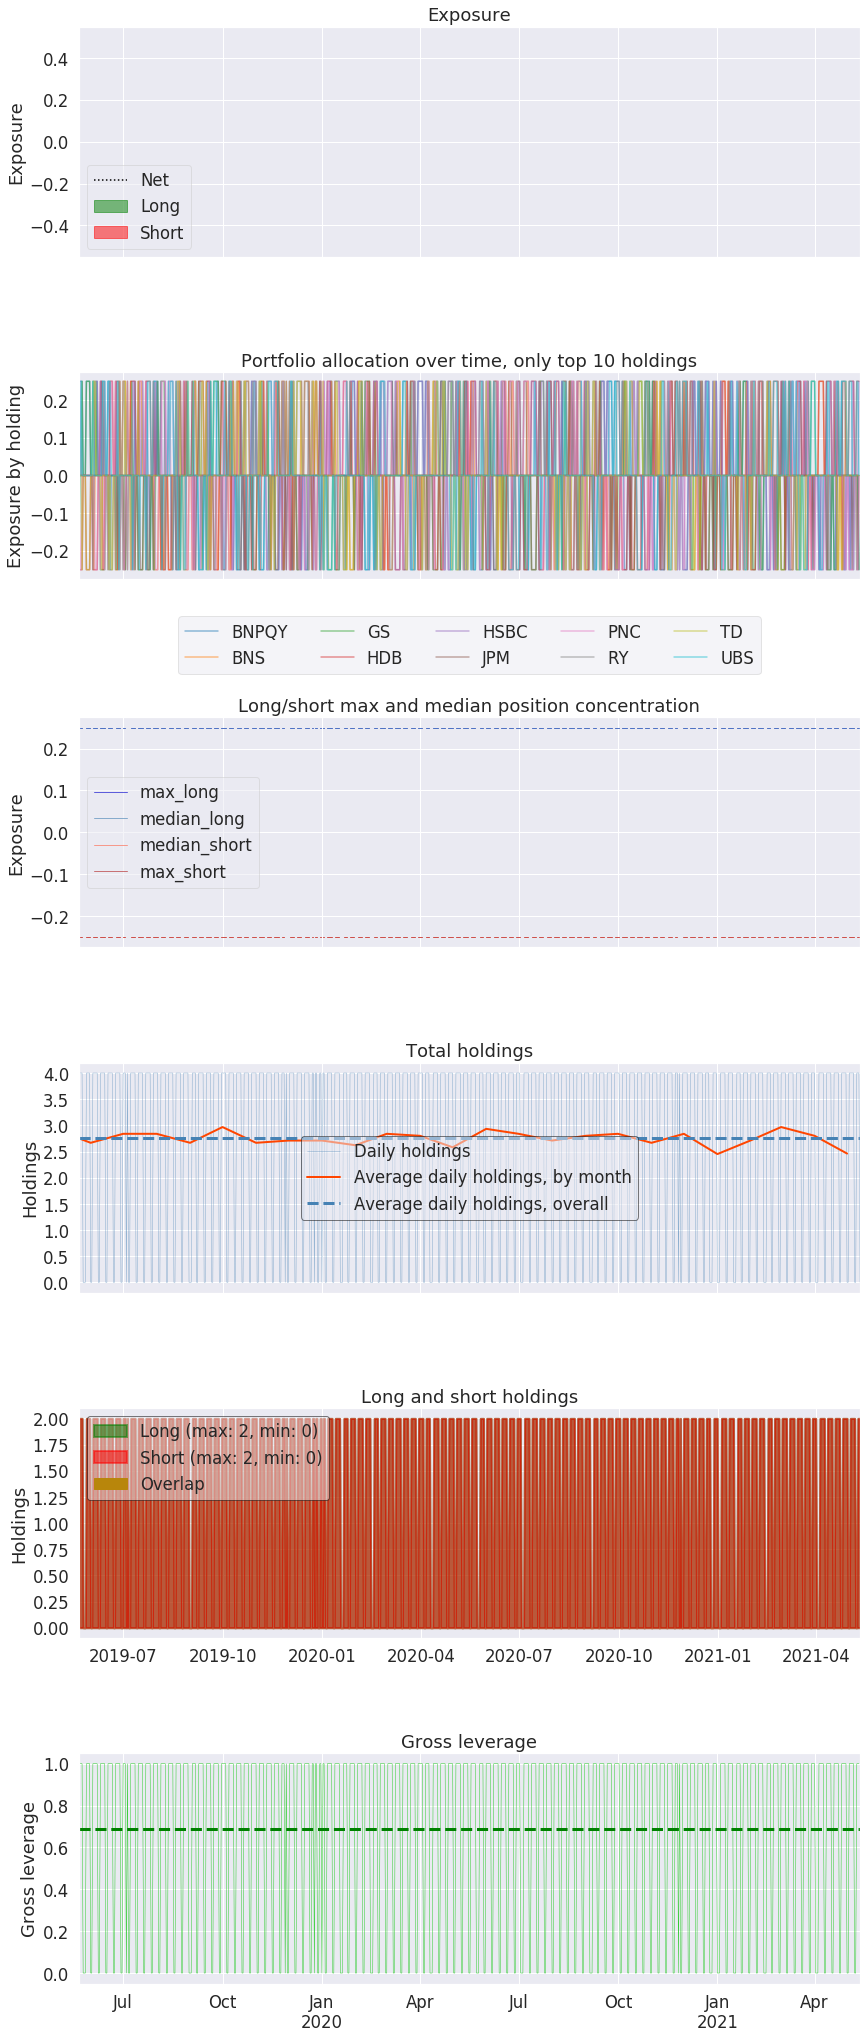

In [38]:
pf.tears.create_full_tear_sheet(pf_returns,
                                     positions=pf_positions,
                                     benchmark_rets=pf_benchmark)

## Non-Predictive Factors

In [40]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(non_predictive_factor,
                                                                   pricing,
                                                                   periods=(1, 3, 5),
                                                                   quantiles=5,
                                                                   bins=None)

Dropped 1.0% entries from factor data: 1.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [41]:
pf_returns, pf_positions, pf_benchmark = \
    alphalens.performance.create_pyfolio_input(factor_data,
                                               period='1D',
                                               capital=100000,
                                               long_short=True,
                                               group_neutral=False,
                                               equal_weight=True,
                                               quantiles=[1,5],
                                               groups=None,
                                               benchmark_period='1D')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/alphalens-0.4.0+0.g77084f1.dirty-py3.7.egg/alphalens/performance.py:399: UserWarning: 'freq' not set, using business day calendar


Start date,2019-05-21
End date,2021-05-12
Total months,34
,Backtest
Annual return,-4.046%
Cumulative returns,-11.174%
Annual volatility,9.948%
Sharpe ratio,-0.37
Calmar ratio,-0.23
Stability,0.82
Max drawdown,-17.331%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.33,2019-07-31,2021-04-01,NaT,NaN
1,3.44,2019-06-06,2019-07-10,2019-07-26,37
2,0.83,2019-06-02,2019-06-03,2019-06-06,4
3,0.52,2019-05-28,2019-05-29,2019-05-31,4
4,0.37,2019-05-21,2019-05-22,2019-05-23,3


Stress Events,mean,min,max
New Normal,-0.01%,-3.16%,2.66%


/Users/snehilkumar/Library/Python/3.7/lib/python/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/snehilkumar/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Top 10 long positions of all time,max
asset,
BNPQY,25.00%
BNS,25.00%
GS,25.00%
HDB,25.00%
HSBC,25.00%
JPM,25.00%
PNC,25.00%
RY,25.00%
TD,25.00%


Top 10 short positions of all time,max
asset,
BNPQY,-25.00%
BNS,-25.00%
GS,-25.00%
HDB,-25.00%
HSBC,-25.00%
JPM,-25.00%
PNC,-25.00%
RY,-25.00%
TD,-25.00%


Top 10 positions of all time,max
asset,
BNPQY,25.00%
BNS,25.00%
GS,25.00%
HDB,25.00%
HSBC,25.00%
JPM,25.00%
PNC,25.00%
RY,25.00%
TD,25.00%


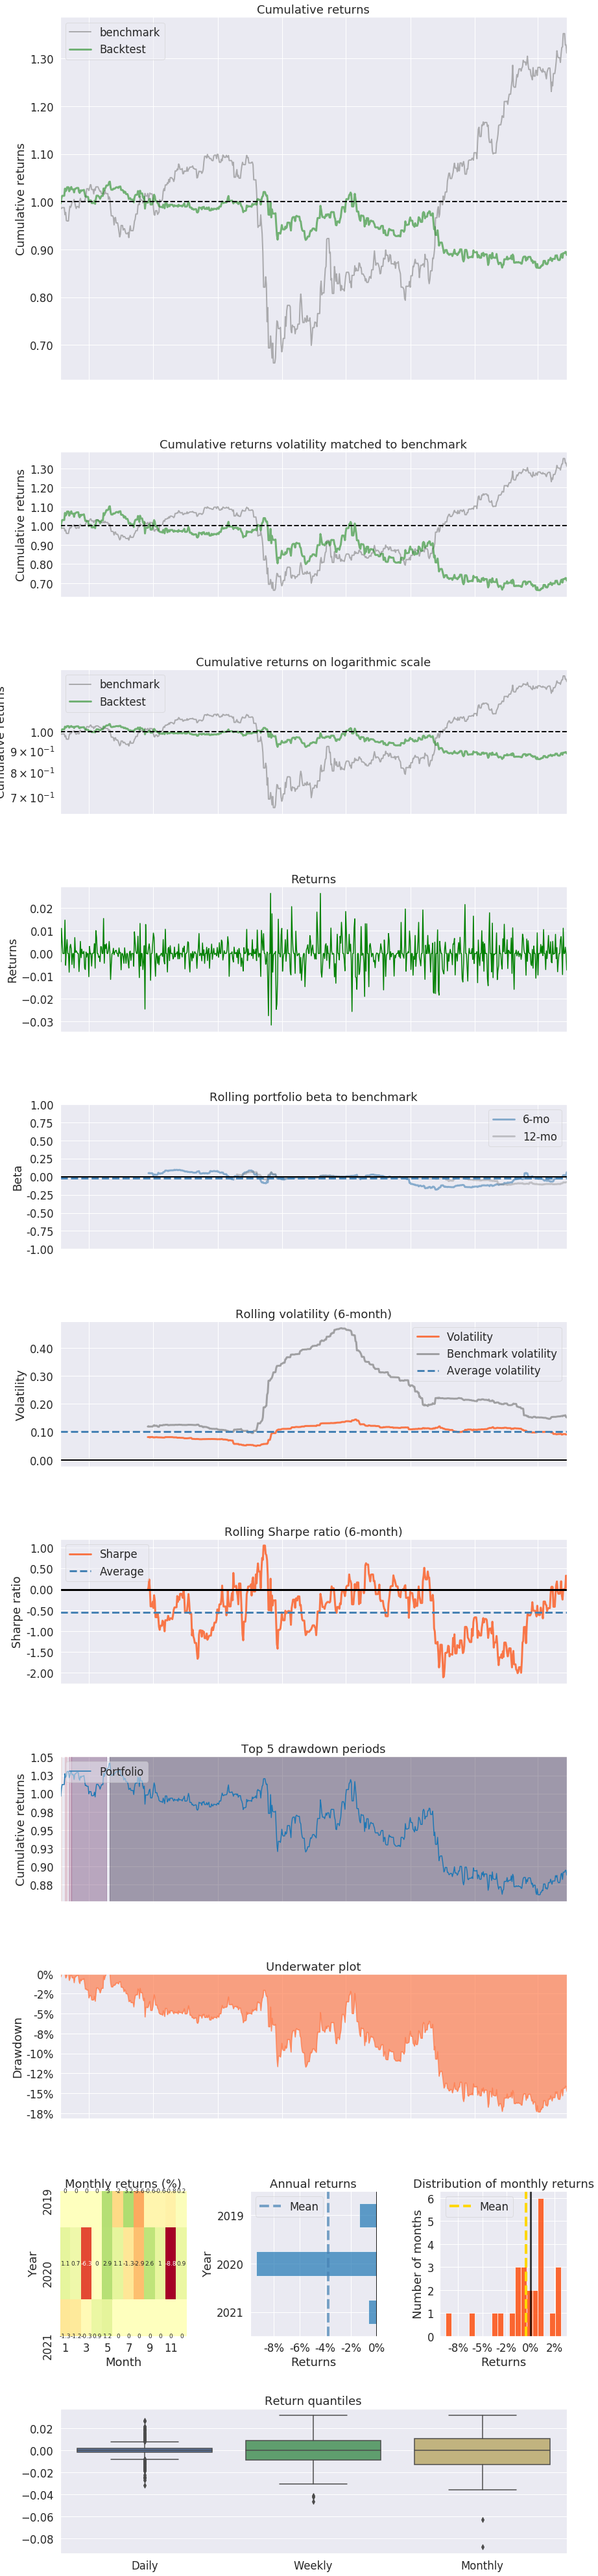

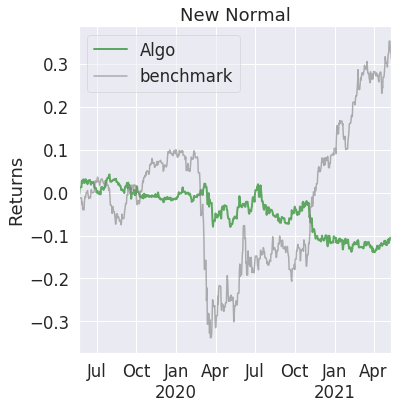

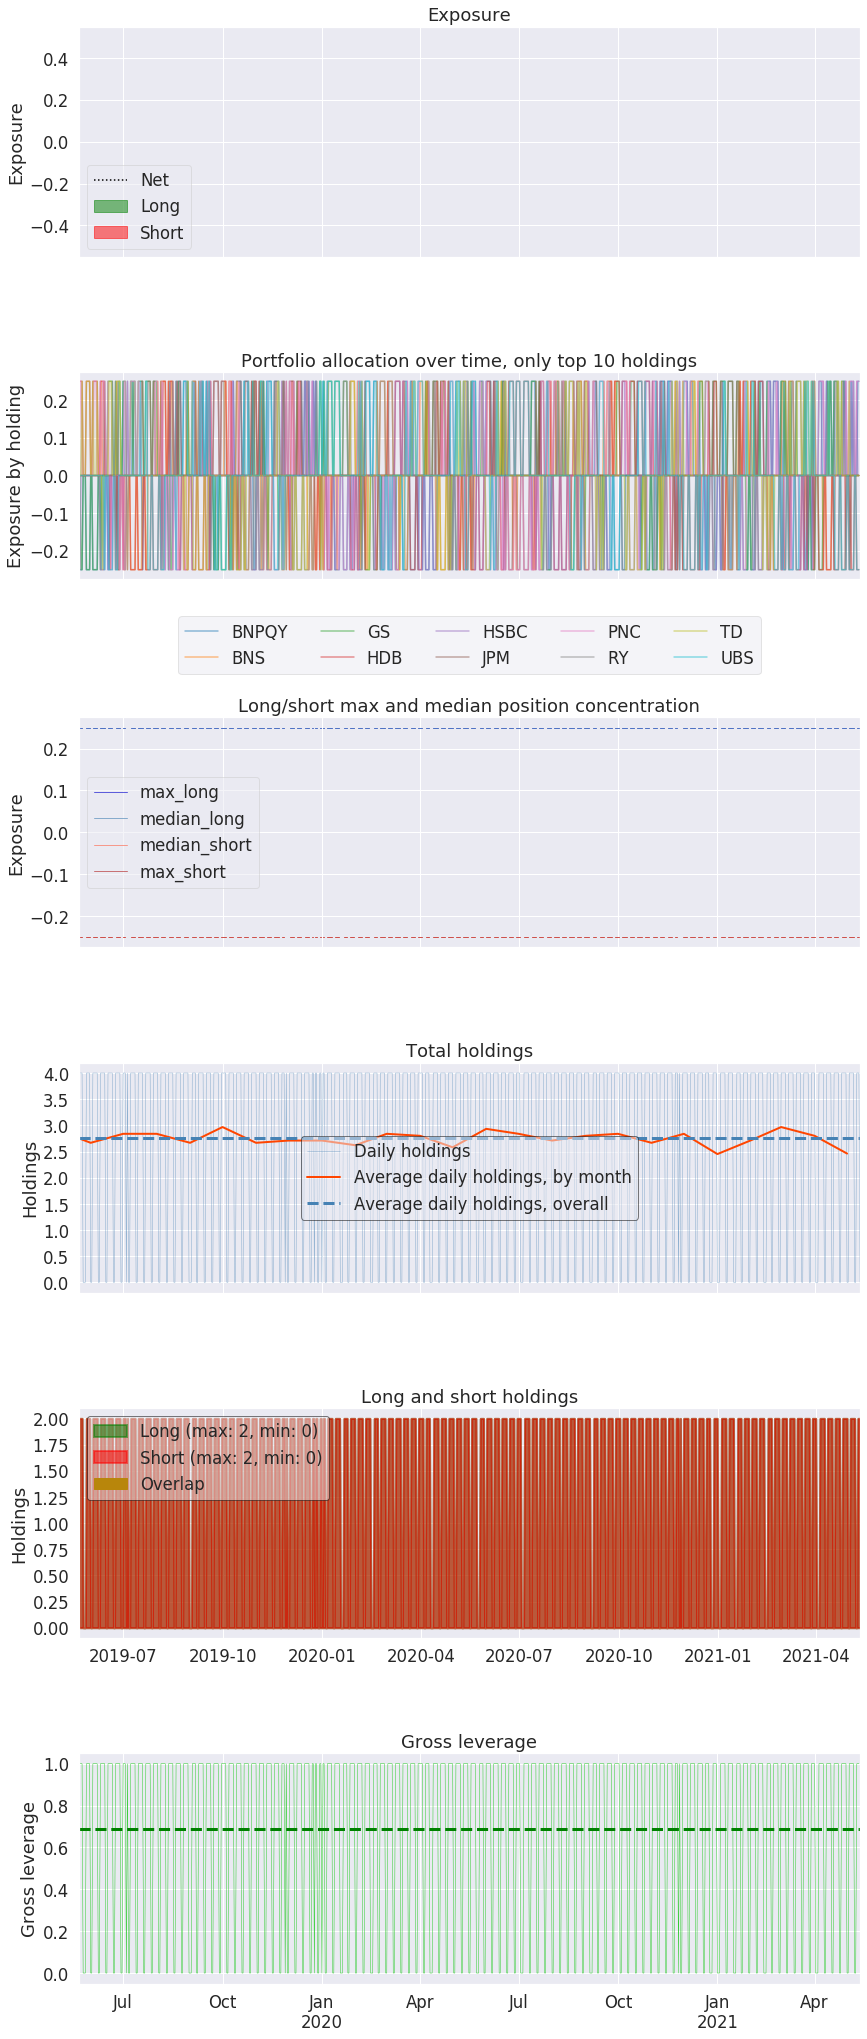

In [42]:
pf.tears.create_full_tear_sheet(pf_returns,
                                     positions=pf_positions,
                                     benchmark_rets=pf_benchmark)